# CREAR BBDD + DATOS


## APLICACION PARA CREAR LA BASE DE DE DATOS

In [ ]:
# =============================================================================
# PROGRAMA 1: CREADOR DE LA BASE DE DATOS
# =============================================================================

from sqlalchemy import create_engine, text
import urllib

# --- Parámetros de conexión ---
SERVER_NAME = r'IBAI\SQLEXPRESS'
DB_TO_CREATE = 'RETO0'
SYSTEM_DB = 'master'  # Conectarse a 'master' para crear otras bases de datos

# --- Conexión al servidor ---
engine = None
try:
    connection_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={SERVER_NAME};"
        f"DATABASE={SYSTEM_DB};"
        f"Trusted_Connection=yes;"
    )
    quoted_conn_str = urllib.parse.quote_plus(connection_string)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")

    print(f"✅ Conexión exitosa con el servidor '{SERVER_NAME}' (usando la BBDD 'master').")

except Exception as e:
    print(f"❌ ERROR: No se pudo conectar al servidor. Verifica el nombre del servidor y que esté en ejecución.")
    print(f"   Detalle del error: {e}")

# --- Ejecución del comando para crear la base de datos ---
if engine is not None:
    try:
        sql_create_db_command = f"""
        IF NOT EXISTS (SELECT name FROM sys.databases WHERE name = N'{DB_TO_CREATE}')
        BEGIN
            CREATE DATABASE [{DB_TO_CREATE}];
        END;
        """
        with engine.connect() as connection:
            connection.execution_options(isolation_level="AUTOCOMMIT").execute(text(sql_create_db_command))

        print(f"✔️ ¡Éxito! La base de datos '{DB_TO_CREATE}' ha sido creada (o ya existía).")

    except Exception as e:
        print(f"❌ ERROR durante la creación de la base de datos: {e}")

## APLICACION PARA BORRAR LAS TABLAS

In [ ]:
# =============================================================================
# PROGRAMA 2: BORRADOR DE TABLAS
# =============================================================================

from sqlalchemy import create_engine, text
import urllib

# --- Parámetros de conexión ---
SERVER_NAME = r'IBAI\SQLEXPRESS'
DATABASE_NAME = 'RETO0'  # Base de datos actualizada

# --- Conexión a la base de datos RETO0 ---
try:
    connection_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={SERVER_NAME};"
        f"DATABASE={DATABASE_NAME};"
        f"Trusted_Connection=yes;"
    )
    quoted_conn_str = urllib.parse.quote_plus(connection_string)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")

    print(f"✅ Conexión exitosa con la BBDD '{DATABASE_NAME}' para borrar tablas.")

    # --- Ejecutar comandos SQL para borrar las tablas ---
    with engine.connect() as connection:
        print("\n🔄 Intentando borrar las tablas...")

        connection.execute(text("DROP TABLE IF EXISTS stocks"))
        print("   -> Tabla 'stocks' borrada con éxito (o no existía).")

        connection.execute(text("DROP TABLE IF EXISTS cryptomonedas"))
        print("   -> Tabla 'cryptomonedas' borrada con éxito (o no existía).")

        connection.commit()

    print("\n🏁 Proceso de borrado finalizado.")

except Exception as e:
    print(f"❌ ERROR durante el proceso de borrado: {e}")

## APLICACION PARA CREAR LAS TABLAS

In [ ]:
# =============================================================================
# PROGRAMA 3: CREADOR DE ESTRUCTURA DE TABLAS (VACÍAS)
# =============================================================================
import pandas as pd
from sqlalchemy import create_engine
import urllib

SERVER_NAME = r'IBAI\SQLEXPRESS'
DATABASE_NAME = 'RETO0'

try:
    connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;"
    quoted_conn_str = urllib.parse.quote_plus(connection_string)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")
    print(f"✅ Conexión exitosa con la BBDD '{DATABASE_NAME}' para crear estructuras.")

    def crear_tabla_vacia_desde_csv(ruta_csv, nombre_tabla):
        print(f"\n🔄 Creando estructura para la tabla '{nombre_tabla}'...")
        # Leemos el CSV para que pandas infiera el esquema (columnas y tipos)
        df_esquema = pd.read_csv(ruta_csv).head(0)
        # Creamos la tabla usando el esquema vacío. 'replace' asegura que se cree limpia.
        df_esquema.to_sql(nombre_tabla, engine, if_exists='replace', index=False)
        print(f"✔️ ¡Éxito! La tabla '{nombre_tabla}' ha sido creada vacía.")

    print("\n🚀 INICIANDO EL SCRIPT DE CREACIÓN DE ESTRUCTURAS...")
    crear_tabla_vacia_desde_csv('stocks.csv', 'stocks')
    crear_tabla_vacia_desde_csv('cryptocurrency.csv', 'cryptomonedas')
    print("\n🏁 Proceso de creación de estructuras finalizado.")

except Exception as e:
    print(f"❌ ERROR: {e}")

## APLICACION PARA INSERTAR DATOS

In [ ]:
# =============================================================================
# PROGRAMA 4: INSERCIÓN DE DATOS EN TABLAS EXISTENTES (VERSIÓN REVISADA)
# =============================================================================
import pandas as pd
from sqlalchemy import create_engine, text
import urllib

SERVER_NAME = r'IBAI\SQLEXPRESS'
DATABASE_NAME = 'RETO0'

try:
    connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;"
    quoted_conn_str = urllib.parse.quote_plus(connection_string)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")
    print(f"✅ Conexión exitosa con la BBDD '{DATABASE_NAME}' para insertar datos.")

    def insertar_datos_en_tabla_existente(ruta_csv, nombre_tabla):
        print(f"\n🔄 Insertando datos en la tabla '{nombre_tabla}'...")

        # --- PASO 1: VACIAR LA TABLA (MÉTODO MÁS ROBUSTO) ---
        # Nos conectamos y ejecutamos TRUNCATE con autocommit para asegurar que se complete inmediatamente.
        with engine.connect() as connection:
            print(f"   -> Vaciando tabla '{nombre_tabla}'...")
            connection.execution_options(isolation_level="AUTOCOMMIT").execute(text(f"TRUNCATE TABLE {nombre_tabla}"))

        # --- PASO 2: INSERTAR LOS NUEVOS DATOS ---
        # Leemos el CSV y lo añadimos a la tabla ya existente y vacía.
        # if_exists='append' es correcto aquí porque la tabla ya está vacía.
        df_datos = pd.read_csv(ruta_csv)
        df_datos.to_sql(nombre_tabla, engine, if_exists='append', index=False)
        print(f"✔️ ¡Éxito! {len(df_datos):,} filas insertadas en '{nombre_tabla}'.".replace(',', '.'))

    print("\n🚀 INICIANDO EL SCRIPT DE INSERCIÓN DE DATOS...")
    insertar_datos_en_tabla_existente('stocks.csv', 'stocks')
    insertar_datos_en_tabla_existente('cryptocurrency.csv', 'cryptomonedas')
    print("\n🏁 Proceso de inserción finalizado.")

except Exception as e:
    print(f"❌ ERROR: {e}")

## APLICACION PARA CREAR LAS TABLAS E INSERTAR DATOS A LA VEZ

In [ ]:
# =============================================================================
# PROGRAMA 3: CREADOR DE TABLAS E INSERCIÓN DE DATOS DESDE CSV
# =============================================================================

import pandas as pd
from sqlalchemy import create_engine
import urllib

# --- Parámetros de conexión ---
SERVER_NAME = r'IBAI\SQLEXPRESS'
DATABASE_NAME = 'RETO0'  # Base de datos actualizada

# --- Conexión a la base de datos RETO0 ---
try:
    connection_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={SERVER_NAME};"
        f"DATABASE={DATABASE_NAME};"
        f"Trusted_Connection=yes;"
    )
    quoted_conn_str = urllib.parse.quote_plus(connection_string)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")
    print(f"✅ Conexión exitosa con la BBDD '{DATABASE_NAME}' para crear/cargar tablas.")
except Exception as e:
    print(f"❌ ERROR: No se pudo establecer la conexión: {e}")
    engine = None

# --- Función de carga de datos ---
def cargar_csv_a_sql(ruta_archivo_csv, nombre_tabla_destino):
    if engine is None:
        return
    try:
        print(f"\n🔄 Procesando '{ruta_archivo_csv}'...")
        df = pd.read_csv(ruta_archivo_csv)
        print(f"   -> Lectura completada: {len(df):,} filas.".replace(',', '.'))
        print(f"   -> Creando/cargando la tabla '{nombre_tabla_destino}'...")
        df.to_sql(nombre_tabla_destino, engine, if_exists='replace', index=False)
        print(f"✔️ ¡Éxito! La tabla '{nombre_tabla_destino}' ha sido creada y los datos cargados.")
    except Exception as e:
        print(f"❌ ERROR durante la carga de '{ruta_archivo_csv}': {e}")

# --- Ejecución del proceso de creación e inserción ---
if __name__ == "__main__" and engine is not None:
    print("\n🚀 INICIANDO EL SCRIPT DE CREACIÓN/CARGA DE TABLAS...")
    cargar_csv_a_sql('stocks.csv', 'stocks')
    cargar_csv_a_sql('cryptocurrency.csv', 'cryptomonedas')
    print("\n🏁 Proceso de carga finalizado. Puedes verificar las tablas en SQL Server.")

# CREACIÓN DE GRAFICOS SEABORN

## GRÁFICOS CRYPTOS

### PREPARACION DE DATOS

In [3]:
import pandas as pd
import datetime

In [5]:
rawdata = pd.read_csv('cryptocurrency.csv')

In [6]:
rawdata

,timestamp,name,symbol,price_usd,vol_24h,total_vol,chg_24h,chg_7d,market_cap
0,2025-09-26 14:35:12,Dogecoin,DOGE,0.223351,$4.20B,1.85%,-4.13%,-18.45%,$33.56B
1,2025-09-26 14:35:12,BNB,BNB,936.1,$4.72B,1.92%,-4.94%,-5.58%,$129.98B
2,2025-09-26 14:35:12,USDC,USDC,0.9993,$25.08B,10.84%,-0.02%,-0.02%,$73.85B
3,2025-09-26 14:35:12,Ethereum,ETH,"3,891.64",$61.10B,27.96%,-2.99%,-14.16%,$468.60B
4,2025-09-26 14:35:12,XRP,XRP,2.7079,$9.25B,3.76%,-3.94%,-10.76%,$161.66B
...,...,...,...,...,...,...,...,...,...
97841,2025-03-17 00:34:14,TRON,TRX,0.212986,$587.69M,1.03%,-4.03%,-9.58%,$20.23B
97842,2025-03-17 00:34:14,Stellar,XLM,0.2661,$153.80M,0.27%,-3.95%,-0.94%,$8.15B
97843,2025-03-17 00:34:14,XRP,XRP,2.3201,$3.85B,6.82%,-4.14%,+6.16%,$134.52B
97844,2025-03-17 00:34:14,USDC,USDC,1,$5.16B,8.43%,+0.01%,+0.00%,$58.72B


In [7]:
rawdata.set_index(rawdata['timestamp'], inplace = True)

In [8]:
del rawdata['timestamp']

In [9]:
rawdata

,name,symbol,price_usd,vol_24h,total_vol,chg_24h,chg_7d,market_cap
timestamp,,,,,,,,
2025-09-26 14:35:12,Dogecoin,DOGE,0.223351,$4.20B,1.85%,-4.13%,-18.45%,$33.56B
2025-09-26 14:35:12,BNB,BNB,936.1,$4.72B,1.92%,-4.94%,-5.58%,$129.98B
2025-09-26 14:35:12,USDC,USDC,0.9993,$25.08B,10.84%,-0.02%,-0.02%,$73.85B
2025-09-26 14:35:12,Ethereum,ETH,"3,891.64",$61.10B,27.96%,-2.99%,-14.16%,$468.60B
2025-09-26 14:35:12,XRP,XRP,2.7079,$9.25B,3.76%,-3.94%,-10.76%,$161.66B
...,...,...,...,...,...,...,...,...
2025-03-17 00:34:14,TRON,TRX,0.212986,$587.69M,1.03%,-4.03%,-9.58%,$20.23B
2025-03-17 00:34:14,Stellar,XLM,0.2661,$153.80M,0.27%,-3.95%,-0.94%,$8.15B
2025-03-17 00:34:14,XRP,XRP,2.3201,$3.85B,6.82%,-4.14%,+6.16%,$134.52B


In [10]:
import pandas as pd
import numpy as np

def convertir_valor(valor):
    if pd.isna(valor):
        return np.nan

    s = str(valor).strip()
    # quitar símbolos comunes
    s = s.replace("$", "").replace(",", "").replace("%", "").replace("T", "").strip()

    # valores no válidos
    if s in ("", "-", "—", "N/A", "na", "NA"):
        return np.nan

    # procesar sufijos
    if "B" in s:
        return float(s.replace("B", "")) * 1000   # Billions → millones
    elif "M" in s:
        return float(s.replace("M", ""))          # Millions → millones
    elif "K" in s:
        return float(s.replace("K", "")) / 1000   # Thousands → millones
    elif "T" in s:
        return float(s.replace("T", "")) * 1000000   # Trillions → trillones
    else:
        return float(s)   # número normal o porcentaje ya limpio

def limpiar_dataframe(df):
    df_limpio = df.copy()
    for col in df_limpio.columns:
        try:
            df_limpio[col] = df_limpio[col].apply(convertir_valor)
        except Exception:
            # si la columna no es convertible (ej. texto puro como "name" o "symbol"),
            # simplemente la dejamos igual
            pass
    return df_limpio



In [11]:
# Supongamos que tu dataframe original es rawdata
df_limpio = limpiar_dataframe(rawdata)

display(df_limpio)

,name,symbol,price_usd,vol_24h,total_vol,chg_24h,chg_7d,market_cap
timestamp,,,,,,,,
2025-09-26 14:35:12,Dogecoin,DOGE,0.223351,4200.00,1.85,-4.13,-18.45,33560.0
2025-09-26 14:35:12,BNB,BNB,936.100000,4720.00,1.92,-4.94,-5.58,129980.0
2025-09-26 14:35:12,USDC,USDC,0.999300,25080.00,10.84,-0.02,-0.02,73850.0
2025-09-26 14:35:12,Ethereum,ETH,3891.640000,61100.00,27.96,-2.99,-14.16,468600.0
2025-09-26 14:35:12,XRP,XRP,2.707900,9250.00,3.76,-3.94,-10.76,161660.0
...,...,...,...,...,...,...,...,...
2025-03-17 00:34:14,TRON,TRX,0.212986,587.69,1.03,-4.03,-9.58,20230.0
2025-03-17 00:34:14,Stellar,XLM,0.266100,153.80,0.27,-3.95,-0.94,8150.0
2025-03-17 00:34:14,XRP,XRP,2.320100,3850.00,6.82,-4.14,6.16,134520.0


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Si el índice se llama 'timestamp' o contiene fechas
if df_limpio.index.name == 'timestamp' or 'timestamp' not in df_limpio.columns:
    df_limpio = df_limpio.reset_index()   # convierte el índice en columna 'timestamp'

# 1) Asegúrate de tener df_limpio
# print(df_limpio.head())

# 2) Normalizar nombres de columnas (quita espacios y pasa a minúsculas)
df = df_limpio.rename(columns=lambda c: str(c).strip().lower())

# 3) Intentar identificar la columna de tiempo entre opciones comunes
possible_time_cols = ['timestamp', 'time', 'date', 'datetime', 'created_at', 'ts', 'fecha']
time_col = next((c for c in possible_time_cols if c in df.columns), None)

if time_col is None:
    raise KeyError("No se encontró ninguna columna de fecha/tiempo. Columnas disponibles: " + ", ".join(df.columns))

# 4) Convertir a datetime con coerción (invalidos -> NaT)
df[time_col] = pd.to_datetime(df[time_col], errors='coerce', utc=False)

# 5) Eliminar filas sin fecha válida
df = df.dropna(subset=[time_col])

# 6) Crear columna YYYY-MM (fecha_ym)
df['fecha_ym'] = df[time_col].dt.to_period('M').astype(str)

# 7) Fecha límite 5 meses atrás (desde ahora)
fecha_limite = pd.Timestamp.now() - pd.DateOffset(months=5)
df_5m = df[df[time_col] >= fecha_limite]

# 8) Filtrar top5 (asegúrate del nombre exacto de la columna 'name' o 'moneda')
name_col = 'name' if 'name' in df.columns else next((c for c in ['moneda','symbol','asset'] if c in df.columns), None)
if name_col is None:
    raise KeyError("No se encontró columna 'name' ni alternativa. Columnas: " + ", ".join(df.columns))

top5_valiosas = ["Bitcoin", "Ethereum", "Solana", "BNB", "Tether", "Tether USDT", "Tether USDt"]
df_top5_valiosas = df_5m[df_5m[name_col].isin(top5_valiosas)]

print("Criptomonedas incluidas:", df_top5_valiosas[name_col].unique())
print("Desde:", df_top5_valiosas[time_col].min(), "hasta:", df_top5_valiosas[time_col].max())

Criptomonedas incluidas: ['BNB' 'Ethereum' 'Bitcoin' 'Solana' 'Tether USDt']
Desde: 2025-05-14 14:34:13 hasta: 2025-09-26 14:35:12


In [13]:
# Si quieres usar solo las filas de df_top5_valiosas, crea ese DataFrame filtrado
top5 = ["Bitcoin","Ethereum","Solana","BNB","Tether"]
df_top5 = df[df['name'].isin(top5)].copy()

#### Grafico 1
El eje X muestra el tiempo (fechas), el eje Y el precio en USD y cada color corresponde a una criptomoneda distinta; cada punto representa una observación de precio en una fecha determinada.

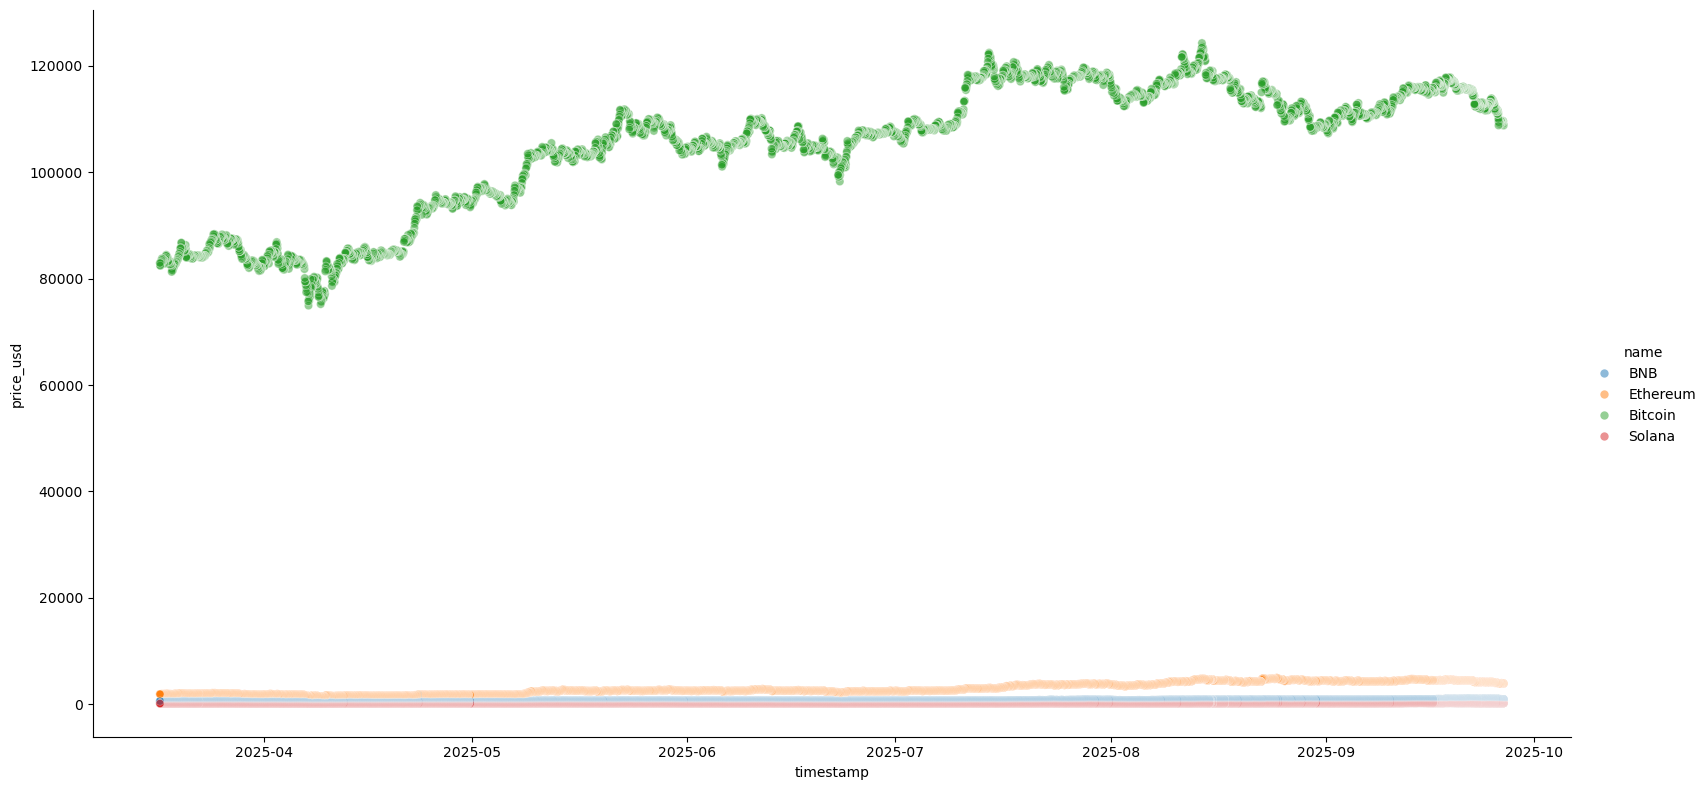

In [14]:
sns.relplot(data=df_top5, x="timestamp", y="price_usd", hue="name",
            height=8, aspect=2, alpha=.5, legend='full');

#### Gráfico 2
Muestra la evolución temporal de la capitalización de mercado mediana, es decir, es el valor total de una criptomoneda: precio actual multiplicado por todas las monedas que existen.

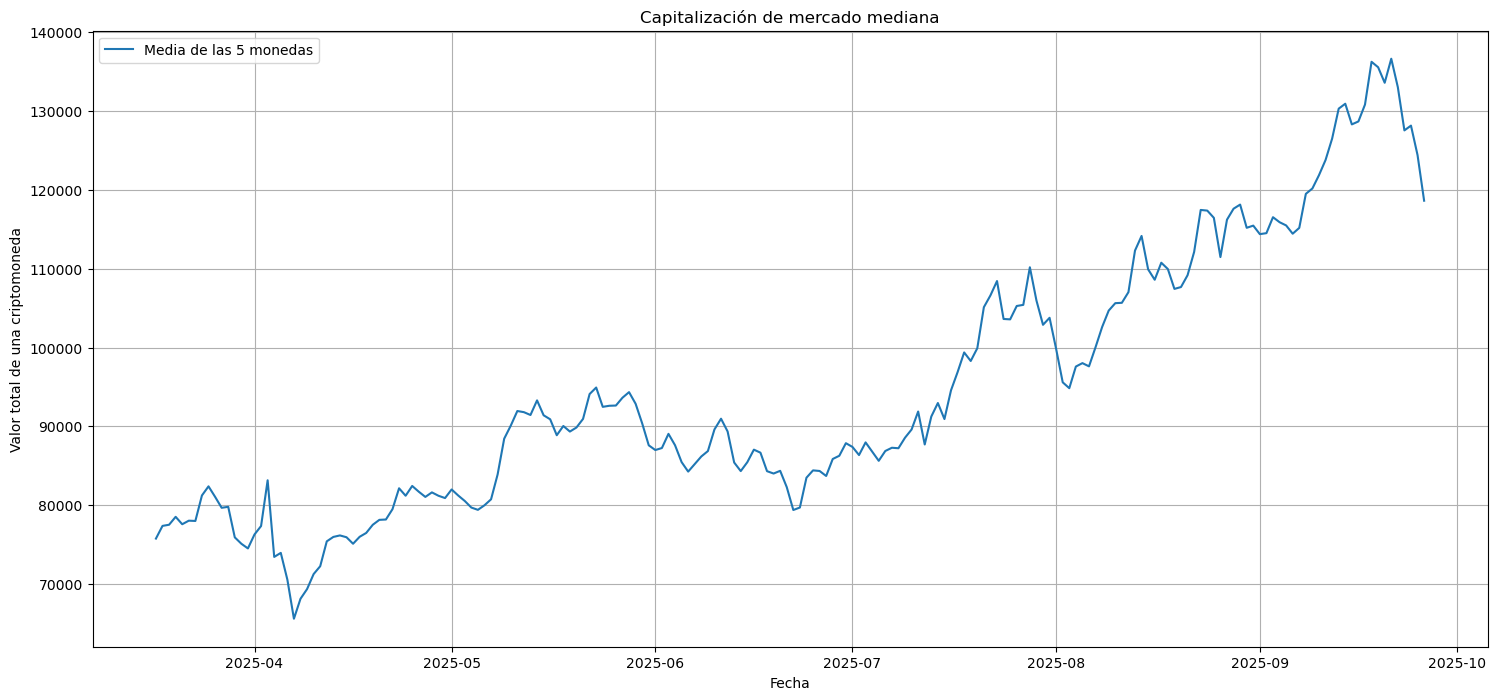

In [15]:
df1 = df_top5.set_index('timestamp').resample('D')['market_cap'].median().rename('market_cap').reset_index()

fig, ax = plt.subplots(figsize=(18, 8))
sns.lineplot(data=df1, x='timestamp', y='market_cap', ax=ax, label='Media de las 5 monedas')

# Etiquetar ejes
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor total de una criptomoneda');
ax.set_title('Capitalización de mercado mediana')

# Agregar leyenda
ax.legend()

# Activar o desactivar grilla
ax.grid(True);

plt.savefig('grafico_capitalización_mercado.png', dpi=300, bbox_inches='tight')

#### Gráfico 3
El volumen es la cantidad de moneda que se compra y vende en un periodo concreto.

La nube principal muestra que la mayor parte de las observaciones de BNB ocurre con volumen 24h alto (derecha) y precios concentrados entre ~600–1000 USD, lo que indica que normalmente BNB se negocia con mucha actividad y precios relativamente estables en ese rango.

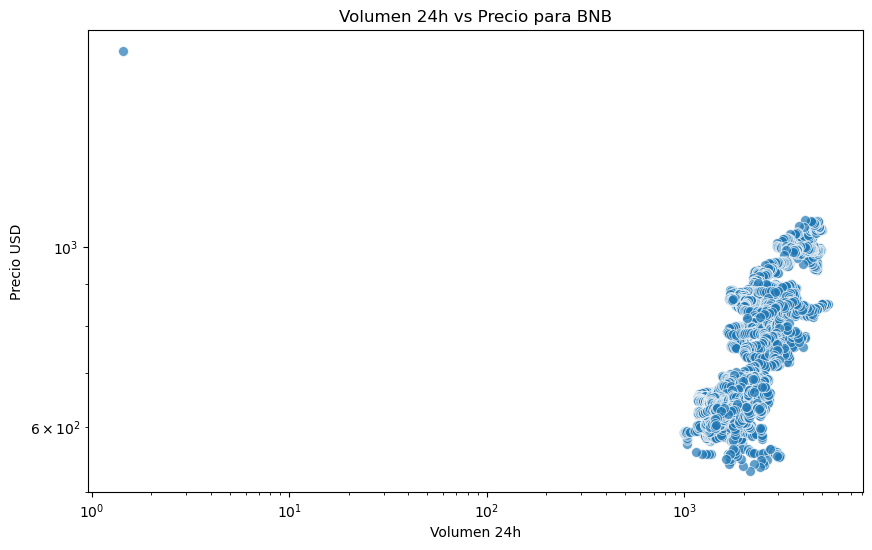

In [16]:
coin = 'BNB' # sustituye por la moneda que quieras

df_coin = df_top5[df_top5['name'] == coin].copy()
df_coin['price_usd'] = pd.to_numeric(df_coin['price_usd'], errors='coerce')
df_coin['vol_24h'] = pd.to_numeric(df_coin['vol_24h'], errors='coerce')
df_coin = df_coin.dropna(subset=['price_usd','vol_24h'])

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_coin, x='vol_24h', y='price_usd', alpha=0.7, s=50, color='C0')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Volumen 24h')
plt.ylabel('Precio USD')
plt.title(f'Volumen 24h vs Precio para {coin}');

#### Gráfico 4
Muestra la evolución del precio en USD a lo largo del tiempo, una línea por cada criptomoneda. Explicación: ideal para ver tendencias y comparar comportamientos temporales entre monedas.

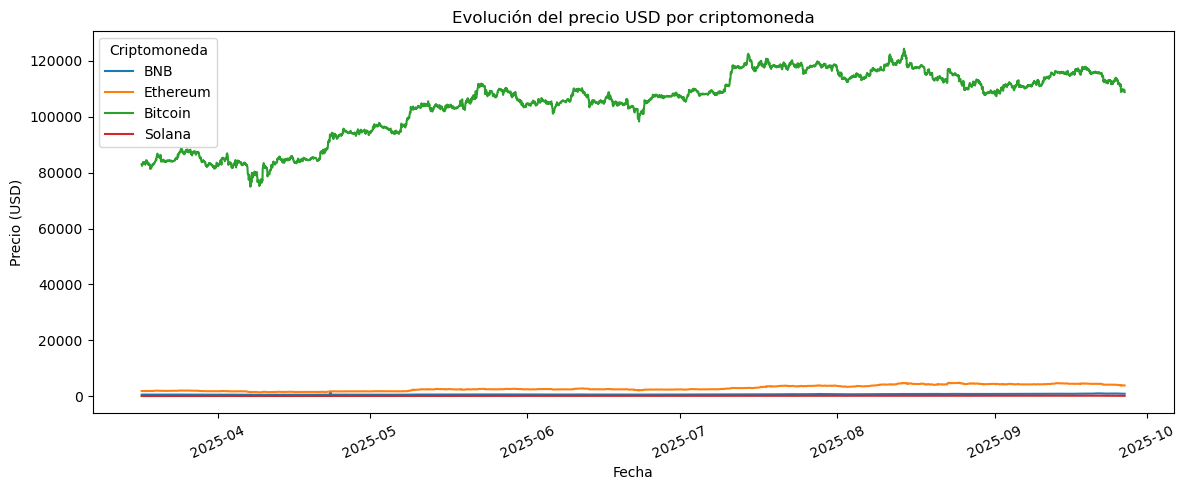

In [17]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_top5, x='timestamp', y='price_usd', hue='name', estimator=None)
plt.title('Evolución del precio USD por criptomoneda')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend(title='Criptomoneda')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

#### Gráfico 5
Scatter plot: price_usd vs vol_24h (tamaño = market_cap, color = name)

Compara precio y volumen, mostrando también el tamaño de mercado.

Explicación: verás si a mayor precio suele corresponder mayor volumen y cómo influye la capitalización.

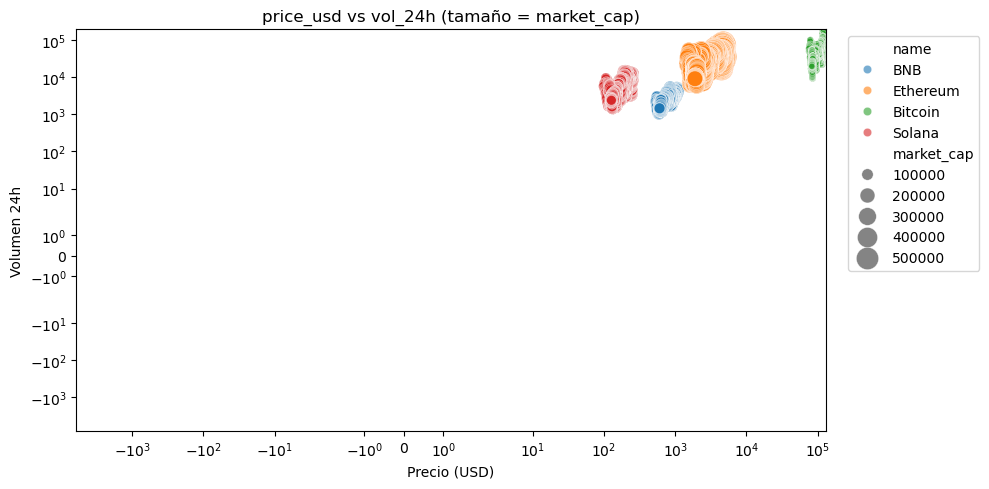

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_top5, x='price_usd', y='vol_24h', hue='name',
                size='market_cap', sizes=(20,300), alpha=0.6, legend='brief')
plt.xscale('symlog')   # si hay mucha diferencia de escala
plt.yscale('symlog')
plt.xlabel('Precio (USD)')
plt.ylabel('Volumen 24h')
plt.title('price_usd vs vol_24h (tamaño = market_cap)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

#### Gráfico 6
Regresión (regplot) por todas las monedas: price_usd vs market_cap (una regresión por moneda)

Ajuste lineal por criptomoneda para estudiar relación precio–cap.

Explicación: comprueba si hay relación directa entre capitalización y precio; usar log ayuda cuando hay grandes diferencias.

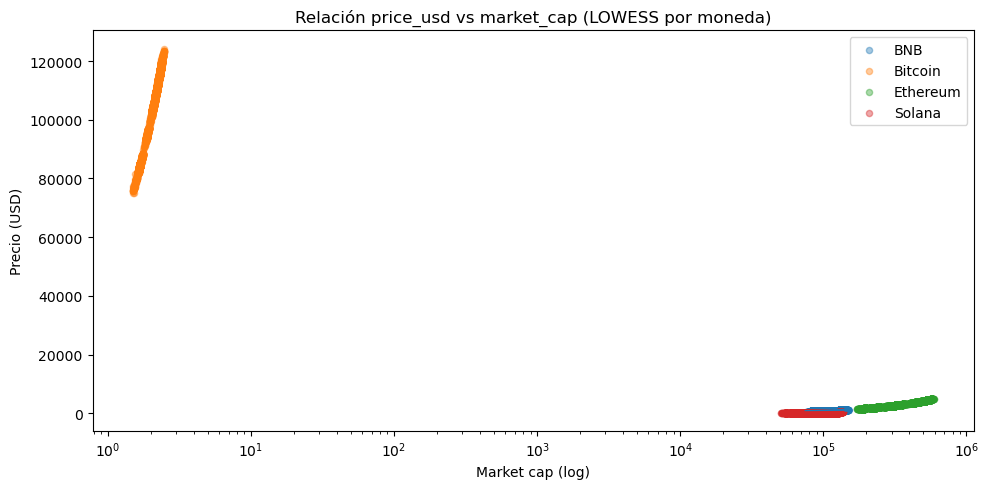

In [19]:
plt.figure(figsize=(10,5))
for name, g in df_top5.groupby('name'):
    sns.regplot(data=g, x='market_cap', y='price_usd', lowess=True, scatter_kws={'s':20, 'alpha':0.4}, label=name)
plt.xscale('log')
plt.xlabel('Market cap (log)')
plt.ylabel('Precio (USD)')
plt.title('Relación price_usd vs market_cap (LOWESS por moneda)')
plt.legend()
plt.tight_layout()
plt.show()

#### Gráfico 7
Barplot: media de chg_7d por criptomoneda (ordenadas)

Compara el rendimiento semanal promedio entre monedas.

Explicación: identifica qué monedas han tendido a subir o bajar más en la última semana.

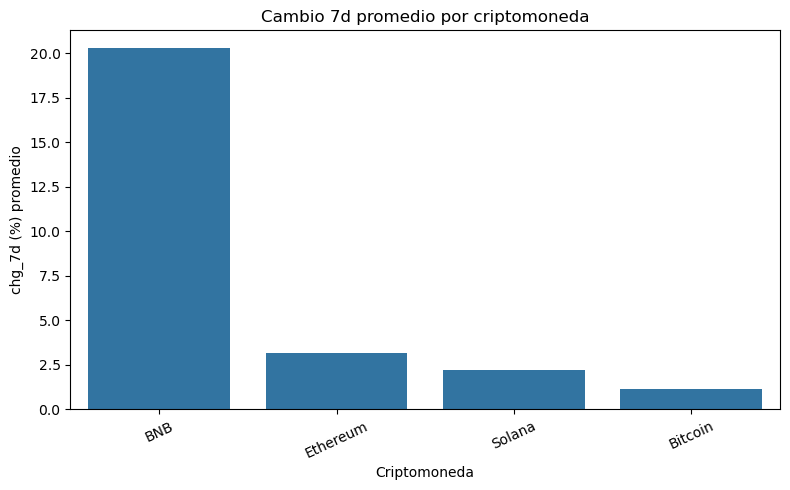

In [20]:
plt.figure(figsize=(8,5))
order = df_top5.groupby('name')['chg_7d'].mean().sort_values(ascending=False).index
sns.barplot(data=df_top5, x='name', y='chg_7d', order=order, errorbar=None)
plt.title('Cambio 7d promedio por criptomoneda')
plt.ylabel('chg_7d (%) promedio')
plt.xlabel('Criptomoneda')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

#### Gráfico 8
Boxplot: vol_24h por criptomoneda (dispersión y outliers)

Distribución del volumen por moneda.

Explicación: compara la variabilidad del volumen; con symlog se manejan mejor outliers.

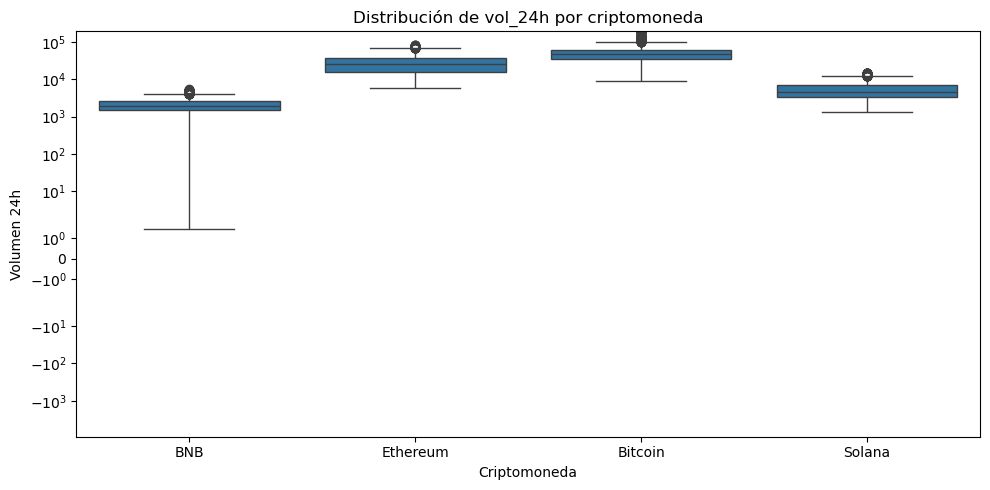

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_top5, x='name', y='vol_24h')
plt.yscale('symlog')
plt.title('Distribución de vol_24h por criptomoneda')
plt.xlabel('Criptomoneda')
plt.ylabel('Volumen 24h')
plt.tight_layout()
plt.show()

#### Gráfico 9
Heatmap de correlación por moneda (variables numéricas)

Correlaciones price_usd, vol_24h, chg_24h, chg_7d, market_cap para cada moneda usando subplots.

Explicación: ver qué variables se relacionan entre sí para cada moneda individualmente.

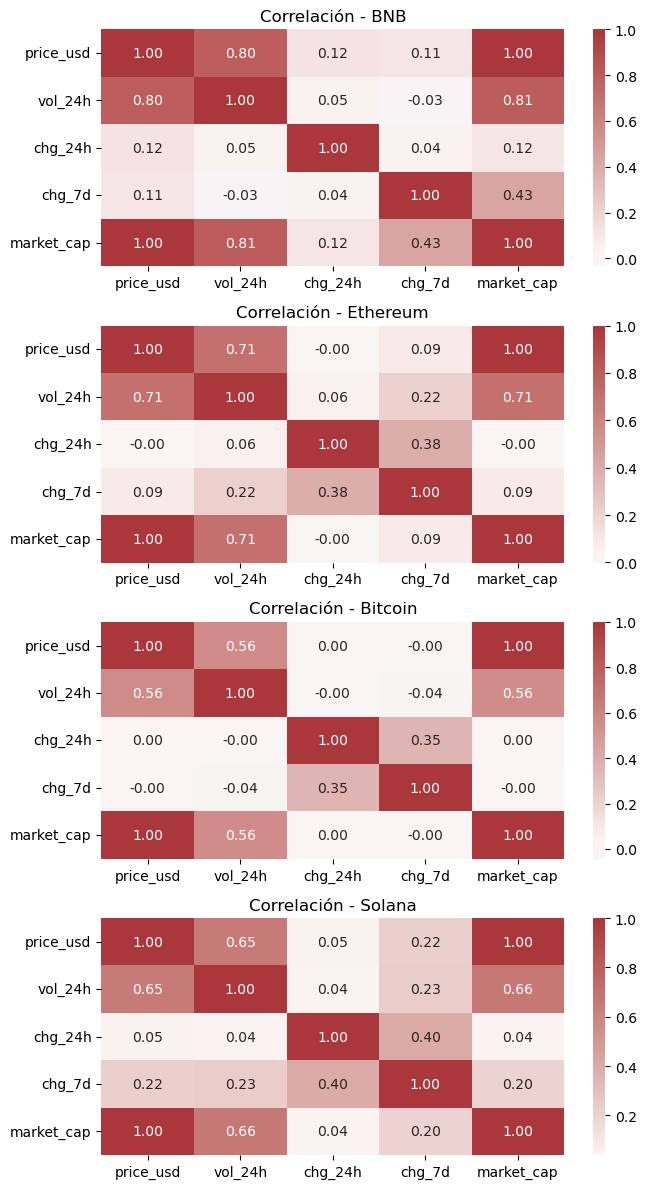

In [22]:
num_cols = ['price_usd','vol_24h','chg_24h','chg_7d','market_cap']
names = df_top5['name'].unique()
n = len(names)
fig, axes = plt.subplots(n, 1, figsize=(7, 3*n))
if n == 1: axes = [axes]
for ax, name in zip(axes, names):
    corr = df_top5[df_top5['name']==name][num_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0, ax=ax)
    ax.set_title(f'Correlación - {name}')
plt.tight_layout()
plt.show()

#### Gráfico 10
ime series area (apilada) de market_cap por moneda (por fecha)

Suma la capitalización por fecha y muestra la participación relativa (stacked area).

Explicación: permite ver la evolución de la cuota de mercado de cada moneda a lo largo del tiempo.

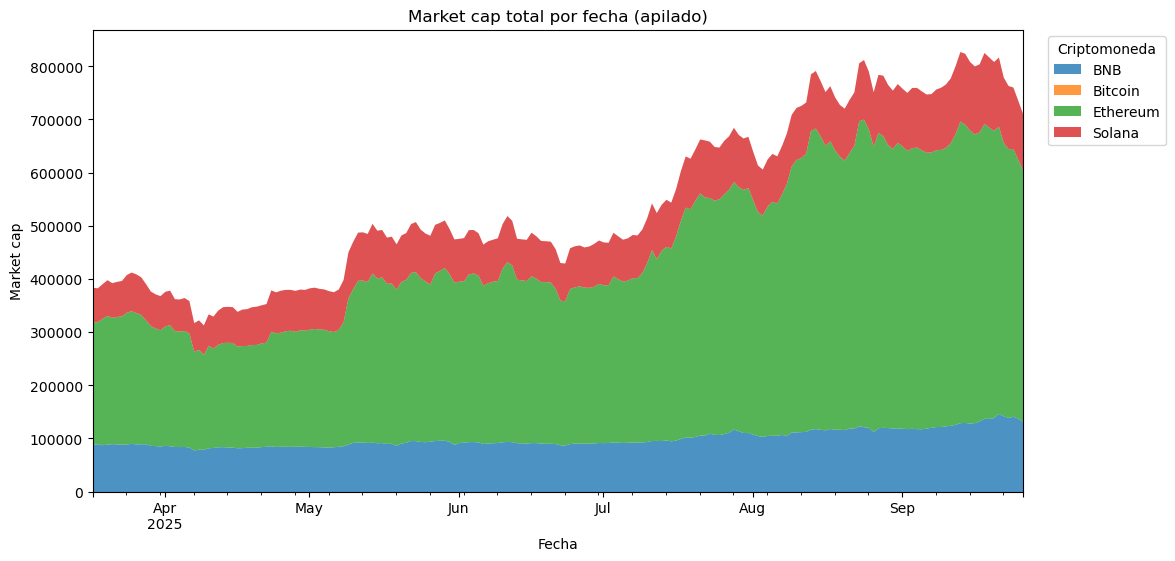

In [23]:
# Pivotear por fecha y moneda
pivot = df_top5.pivot_table(index='timestamp', columns='name', values='market_cap', aggfunc='mean').fillna(0)
pivot_resampled = pivot.resample('D').mean().interpolate()  # agrupar por día y rellenar

pivot_resampled.plot.area(alpha=0.8, linewidth=0, figsize=(12,6))
plt.title('Market cap total por fecha (apilado)')
plt.xlabel('Fecha')
plt.ylabel('Market cap')
plt.legend(title='Criptomoneda', bbox_to_anchor=(1.02,1), loc='upper left');

#### Gráfico 11
Stacked area normalizado (porcentaje del total) — ver cuota de mercado relativa

Si usas stacked area pero quieres que muestre participación relativa, normaliza por la suma total por fecha.

Cuándo: quieres mostrar cómo cambia la participación de mercado de cada moneda a lo largo del tiempo.

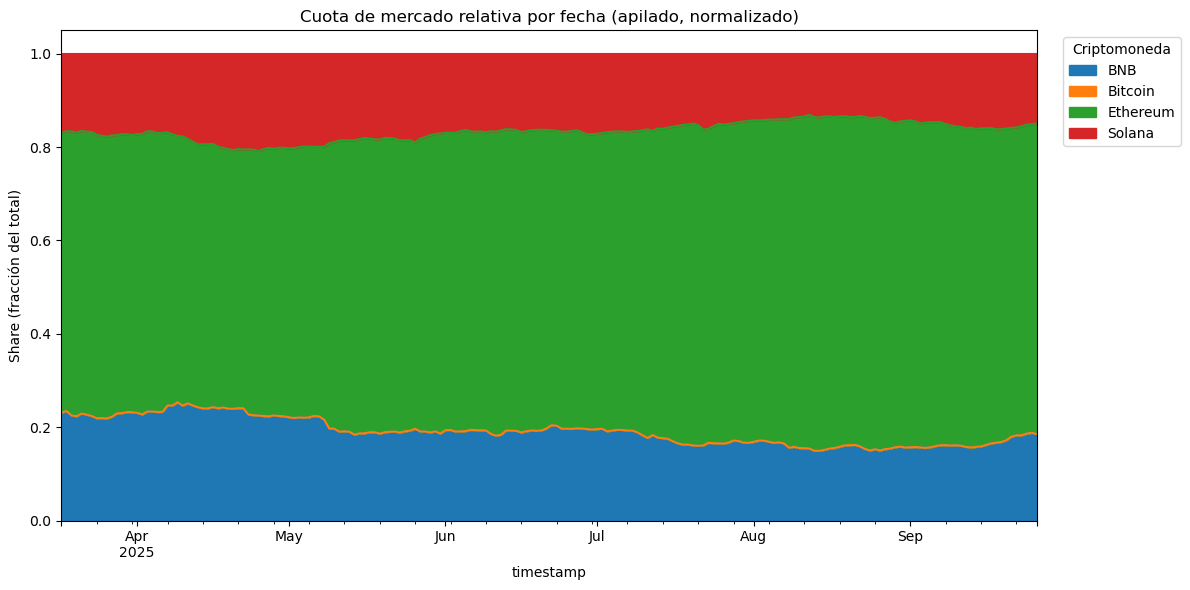

In [24]:
pivot = df_top5.pivot_table(index='timestamp', columns='name', values='market_cap', aggfunc='mean').fillna(0)
pivot_resampled = pivot.resample('D').mean().interpolate()

pivot_pct = pivot_resampled.div(pivot_resampled.sum(axis=1), axis=0)  # cada fila suma 1
pivot_pct.plot.area(figsize=(12,6))
plt.ylabel('Share (fracción del total)')
plt.title('Cuota de mercado relativa por fecha (apilado, normalizado)')
plt.legend(title='Criptomoneda', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

#### Gráfico 12
Swarm + Box (combinado) de chg_24h por name

Boxplot con puntos individuales superpuestos para ver la dispersión.

Explicación: combina resumen estadístico (box) con puntos reales (swarm) para ver la variabilidad y outliers.

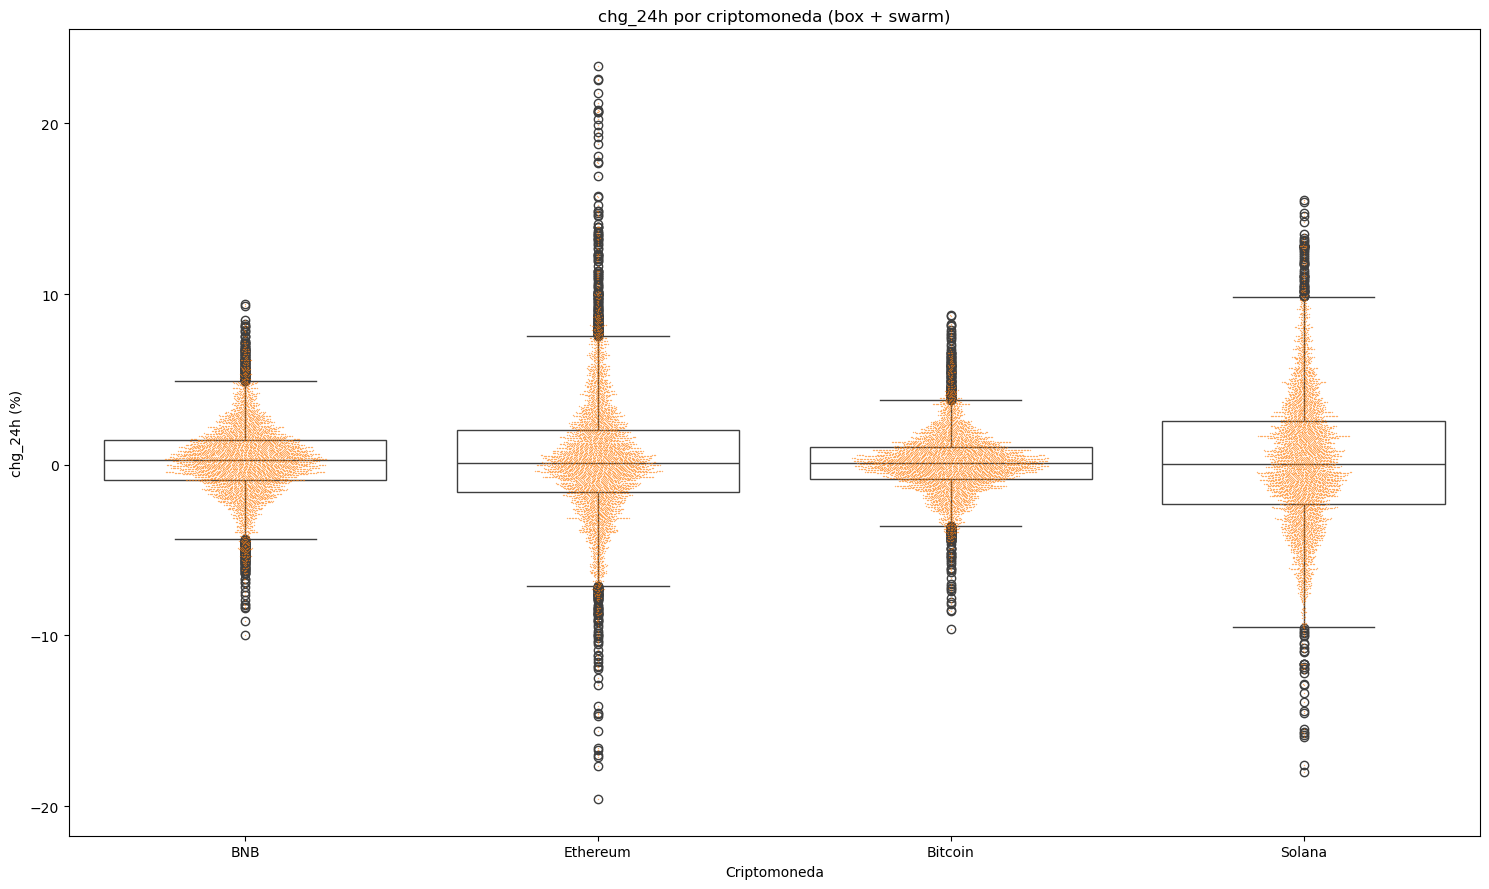

In [25]:
plt.figure(figsize=(15,9))
sns.boxplot(data=df_top5, x='name', y='chg_24h', showcaps=True, boxprops={'facecolor':'None'})
sns.swarmplot(data=df_top5, x='name', y='chg_24h', size=1, alpha=0.6)
plt.title('chg_24h por criptomoneda (box + swarm)')
plt.xlabel('Criptomoneda')
plt.ylabel('chg_24h (%)')
plt.tight_layout()
plt.show()

#### Gráfico 13
Z-score (estandarizar) para comparar variabilidad relativa

Estandariza (media 0, desviación 1) para ver movimientos relativos respecto a su media.

Cuándo: cuando te interesa comparar volatilidad o desviaciones relativas.

C:\Users\ibaig\AppData\Local\Temp\ipykernel_23488\2936594768.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = df_top5.pivot_table(index='timestamp', columns='name', values='price_usd', aggfunc='mean').fillna(method='ffill')


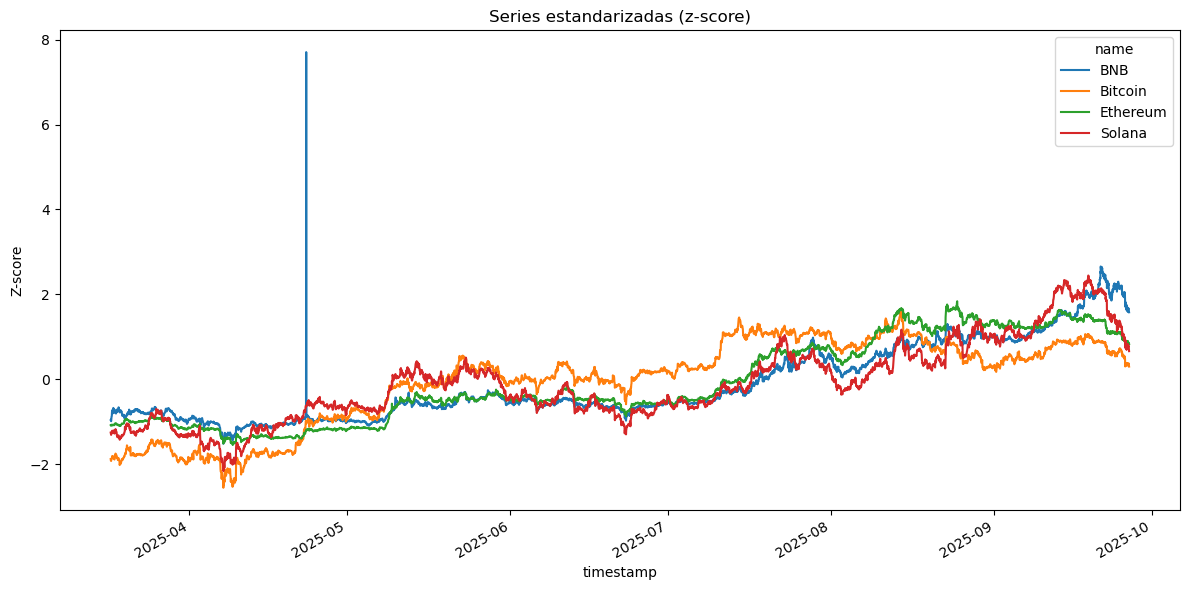

In [26]:
pivot = df_top5.pivot_table(index='timestamp', columns='name', values='price_usd', aggfunc='mean').fillna(method='ffill')
pivot_z = (pivot - pivot.mean()) / pivot.std()
pivot_z.plot(figsize=(12,6))
plt.title('Series estandarizadas (z-score)')
plt.ylabel('Z-score')
plt.tight_layout()
plt.show()

## GRÁFICOS STOCKS

### PREPARACIÓN DE DATOS

In [27]:
# =============================================================================
# # Reto de Consultoría de Datos: Visualización y Análisis (VERSIÓN CORREGIDA)
# Realizado por: Nexus IA
# =============================================================================

# --- INSTALACIÓN DE LIBRERÍAS ADICIONALES ---
!pip install squarify

# =============================================================================
# SECCIÓN 1: PREPARACIÓN DEL ENTORNO Y CARGA INTELIGENTE DE DATOS
# =============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from math import pi

# --- Configuración de estilo global para los gráficos ---
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-talk")

# --- PARÁMETRO CLAVE: TAMAÑO DE LA MUESTRA ---
TAMANO_MUESTRA = 10000

# --- Función de limpieza para convertir valores monetarios a números ---
def convertir_a_numerico(valor):
    if isinstance(valor, str):
        valor_limpio = valor.replace('$', '').strip()
        sufijo = valor_limpio[-1].upper()
        if sufijo == 'M':
            return float(valor_limpio[:-1]) * 1_000_000
        elif sufijo == 'B':
            return float(valor_limpio[:-1]) * 1_000_000_000
    try:
        return float(valor)
    except (ValueError, TypeError):
        return None

# --- Carga y limpieza del dataset de Acciones (Stocks) ---
print(f"🔄 Procesando una muestra de {TAMANO_MUESTRA:,} filas de 'stocks.csv'...")
try:
    df_stocks = pd.read_csv('stocks.csv', nrows=TAMANO_MUESTRA)
    df_stocks['vol_'] = df_stocks['vol_'].apply(convertir_a_numerico)
    df_stocks['timestamp'] = pd.to_datetime(df_stocks['timestamp'])
    df_stocks.dropna(subset=['vol_'], inplace=True)
    print(f"✅ Muestra de 'stocks.csv' cargada. {len(df_stocks)} filas en memoria.")
except Exception as e:
    print(f"❌ ERROR al procesar 'stocks.csv': {e}")

# =============================================================================
# PASO ADICIONAL CLAVE: OBTENER DATOS ÚNICOS POR ACTIVO
# Para evitar el error de que una sola empresa aparezca varias veces en un ranking,
# creamos un nuevo DataFrame que contiene solo el registro más reciente de cada activo.
# =============================================================================
print("\n🔄 Creando listas de activos únicos con sus datos más recientes...")
# Ordenamos por fecha y eliminamos duplicados, quedándonos con la primera aparición (la más reciente)
df_stocks_latest = df_stocks.sort_values('timestamp', ascending=False).drop_duplicates('name')
print("✅ Listas de activos únicos creadas.")

🔄 Procesando una muestra de 10,000 filas de 'stocks.csv'...
✅ Muestra de 'stocks.csv' cargada. 9324 filas en memoria.

🔄 Creando listas de activos únicos con sus datos más recientes...
✅ Listas de activos únicos creadas.


#### GRÁFICO 1

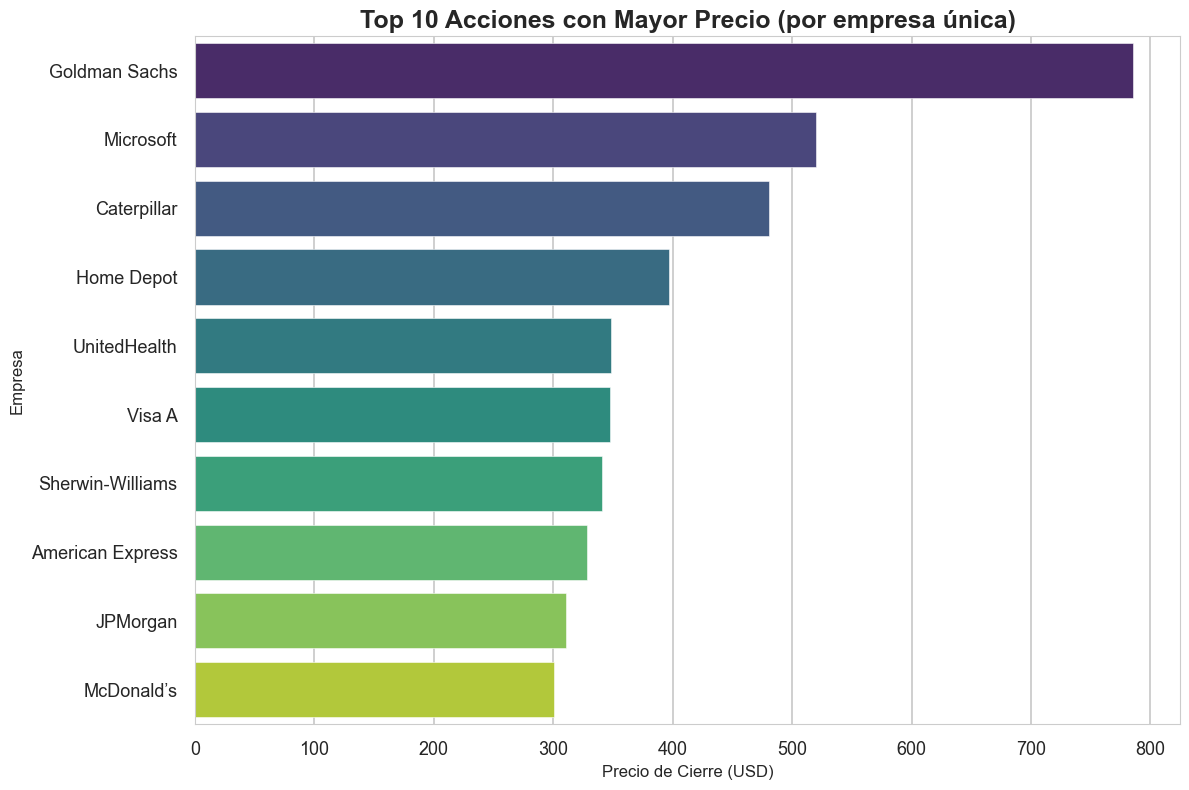

In [28]:
# --- 1. Ranking de las 10 Acciones Más Caras ---
# Gráfico: Barras Horizontales.
# Justificación: Identifica a los líderes por valor nominal. Usamos df_stocks_latest para asegurar 10 empresas distintas.
plt.figure(figsize=(12, 8))
top_10_caras = df_stocks_latest.sort_values('last', ascending=False).head(10)
sns.barplot(x='last', y='name', data=top_10_caras, palette='viridis', hue='name', dodge=False)
plt.title('Top 10 Acciones con Mayor Precio (por empresa única)', fontsize=18, fontweight='bold')
plt.xlabel('Precio de Cierre (USD)', fontsize=12)
plt.ylabel('Empresa', fontsize=12)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

#### GRÁFICO 2

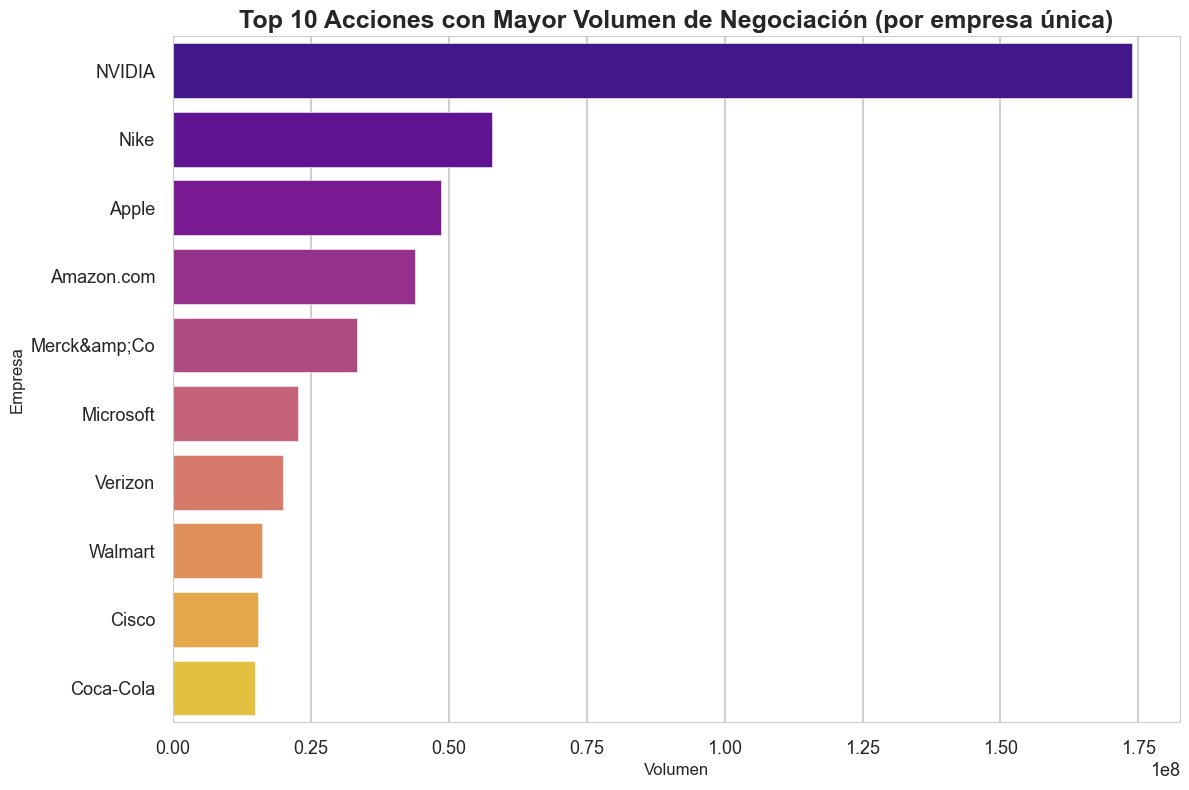

In [29]:
# --- 2. Ranking de las 10 Acciones con Mayor Volumen de Negociación ---
# Gráfico: Barras Horizontales.
# Justificación: Muestra qué acciones son más líquidas y activamente negociadas, usando la lista de empresas únicas.
plt.figure(figsize=(12, 8))
top_10_volumen = df_stocks_latest.sort_values('vol_', ascending=False).head(10)
sns.barplot(x='vol_', y='name', data=top_10_volumen, palette='plasma', hue='name', dodge=False)
plt.title('Top 10 Acciones con Mayor Volumen de Negociación (por empresa única)', fontsize=18, fontweight='bold')
plt.xlabel('Volumen', fontsize=12)
plt.ylabel('Empresa', fontsize=12)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

#### GRÁFICO 3

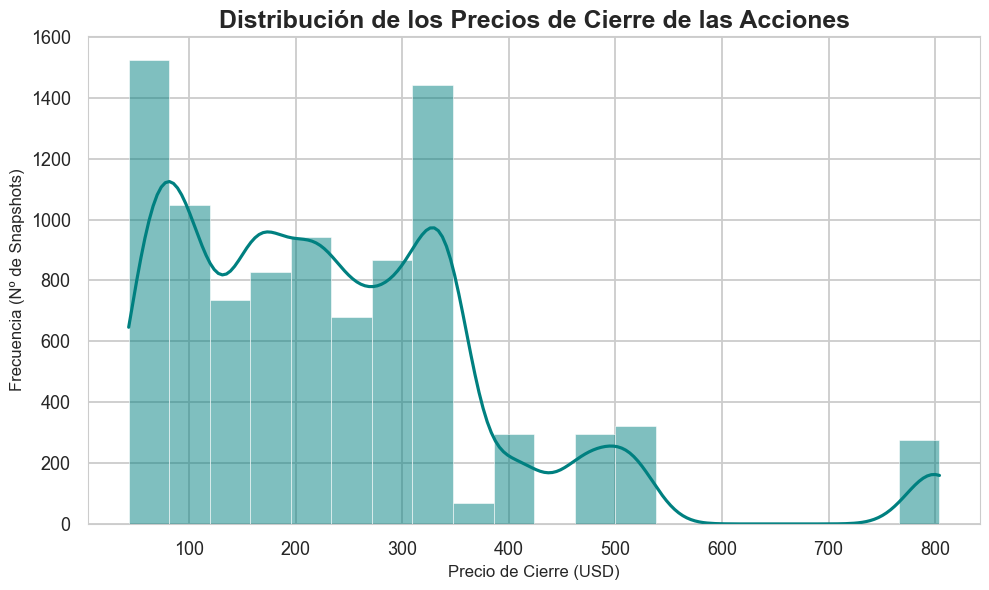

In [30]:
# --- 3. Distribución de los Precios de las Acciones ---
# Gráfico: Histograma.
# Justificación: Muestra la estructura de precios del mercado. Aquí usamos la muestra completa (df_stocks) para tener más datos.
plt.figure(figsize=(10, 6))
sns.histplot(df_stocks['last'], kde=True, color='teal', bins=20)
plt.title('Distribución de los Precios de Cierre de las Acciones', fontsize=18, fontweight='bold')
plt.xlabel('Precio de Cierre (USD)', fontsize=12)
plt.ylabel('Frecuencia (Nº de Snapshots)', fontsize=12)
plt.tight_layout()
plt.show()

#### GRÁFICO 4

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Filtro: top 10 acciones por volumen ---
top10 = df_stocks_latest.nlargest(10, 'vol_')

# Paleta de colores viva
sns.set_palette("husl")

print(top10)

             timestamp          name    last    high     low  chg_   chg_%  \
20 2025-10-02 13:00:01        NVIDIA  187.24  188.14  183.90  0.66  +0.35%   
21 2025-10-02 13:00:01          Nike   74.20   74.69   71.61  4.47  +6.41%   
4  2025-10-02 13:00:01         Apple  255.45  258.79  254.93  0.82  +0.32%   
1  2025-10-02 13:00:01    Amazon.com  220.63  222.15  216.61  1.06  +0.48%   
18 2025-10-02 13:00:01  Merck&amp;Co   90.13   90.75   85.19  6.20  +7.39%   
19 2025-10-02 13:00:01     Microsoft  519.71  520.51  511.69  1.76  +0.34%   
26 2025-10-02 13:00:01       Verizon   43.83   44.09   43.45 -0.12  -0.27%   
28 2025-10-02 13:00:01       Walmart  101.96  102.86  100.55 -1.10  -1.07%   
8  2025-10-02 13:00:01         Cisco   68.75   68.82   67.69  0.33  +0.48%   
10 2025-10-02 13:00:01     Coca-Cola   66.78   66.83   66.29  0.46  +0.69%   

           vol_   time  
20  173840000.0  01/10  
21   57920000.0  01/10  
4    48710000.0  01/10  
1    43930000.0  01/10  
18   33460000.0 

#### GRÁFICO 5
De barras: volumen de cada acción
Muestra qué acciones tienen mayor volumen negociado.

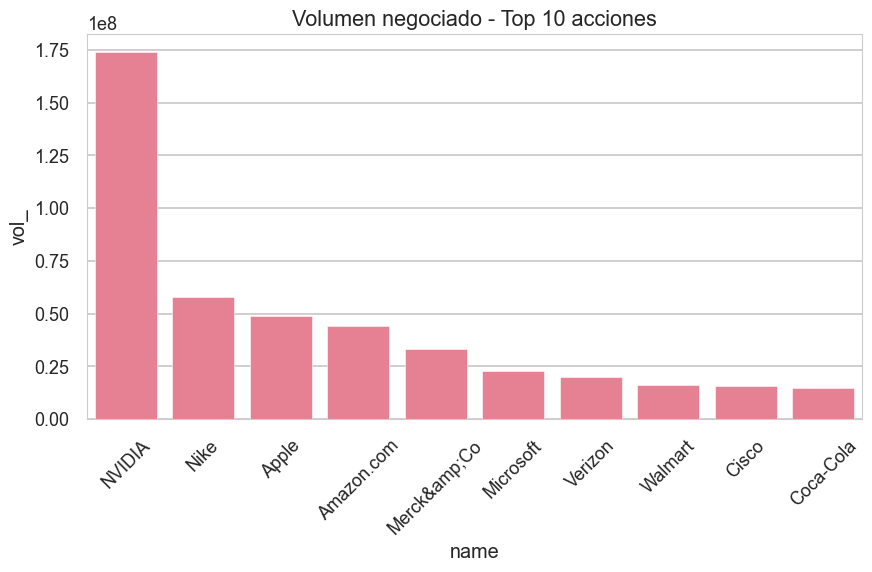

In [32]:
plt.figure(figsize=(10,5))
sns.barplot(x='name', y='vol_', data=top10)
plt.title("Volumen negociado - Top 10 acciones")
plt.xticks(rotation=45)
plt.show()

#### GRÁFICO 6
De puntos (stripplot): cambio porcentual
Cada punto muestra el % de variación de una acción.

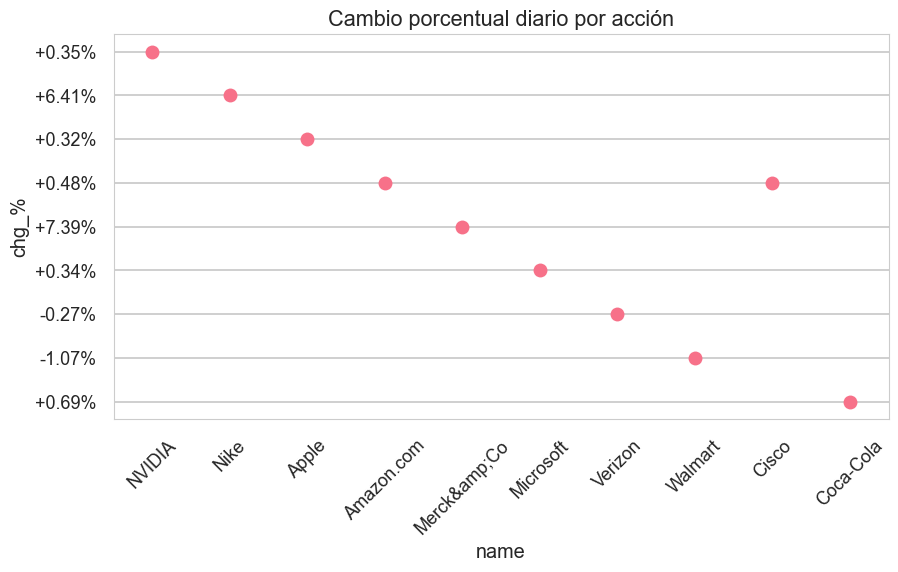

In [33]:
plt.figure(figsize=(10,5))
sns.stripplot(x='name', y='chg_%', data=top10, size=10)
plt.title("Cambio porcentual diario por acción")
plt.xticks(rotation=45)
plt.show()

#### GRÁFICO 7
De dispersión (scatterplot): relación entre precio y volumen
Permite ver si los activos más caros también mueven más volumen.

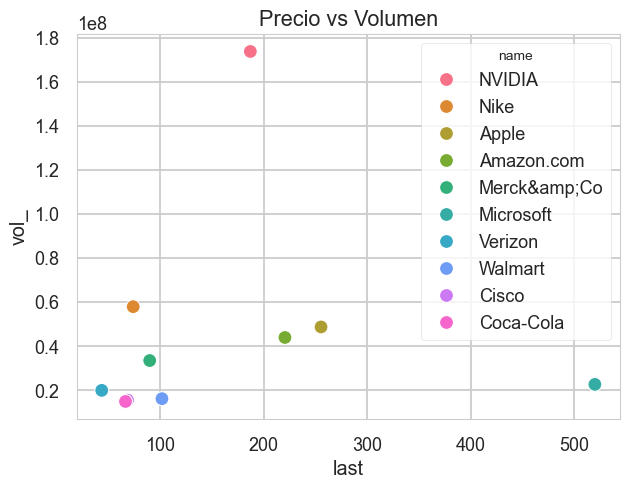

In [34]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='last', y='vol_', hue='name', data=top10, s=100)
plt.title("Precio vs Volumen")
plt.show()

#### GRÁFICO 8
Heatmap (mapa de calor): correlaciones entre variables numéricas
Permite ver qué variables se relacionan más (por ejemplo, last vs high).

In [35]:
# --- Verificamos si hay valores no numéricos en las columnas relevantes ---
cols_numericas = ['last','high','low','chg_','chg_%','vol_']
for col in cols_numericas:
    no_numericos = df_stocks_latest[~df_stocks_latest[col].astype(str).str.replace('[\d\.\-\+%]', '', regex=True).str.strip().eq('')]
    if len(no_numericos) > 0:
        print(f"⚠️ Columna '{col}' tiene valores no numéricos. Ejemplo:")
        print(no_numericos[col].head())

In [36]:
# --- Limpieza robusta de todas las columnas numéricas ---
for col in ['last','high','low','chg_','chg_%','vol_']:
    df_stocks_latest[col] = (
        df_stocks_latest[col]
        .astype(str)
        .str.replace('[\$,%,]', '', regex=True)  # quitamos símbolos
        .str.replace(' ', '', regex=False)       # quitamos espacios
    )
    df_stocks_latest[col] = pd.to_numeric(df_stocks_latest[col], errors='coerce')  # convertimos a float

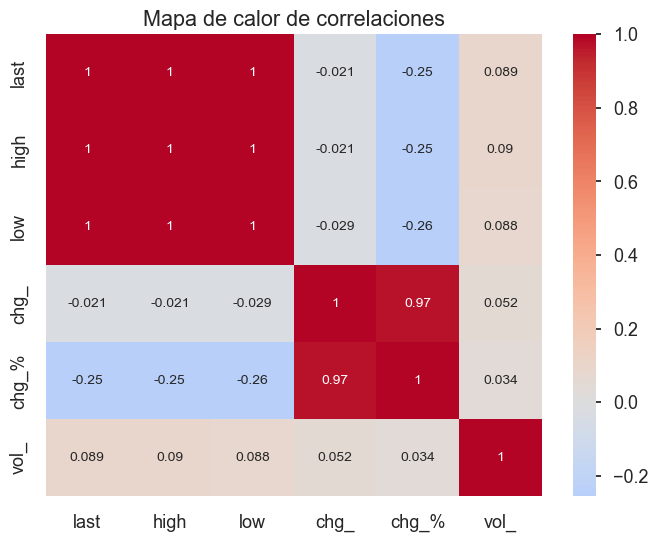

In [37]:
top10 = df_stocks_latest.nlargest(10, 'vol_')

plt.figure(figsize=(8,6))
sns.heatmap(top10[['last','high','low','chg_','chg_%','vol_']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Mapa de calor de correlaciones")
plt.show()

#### GRÁFICO 10

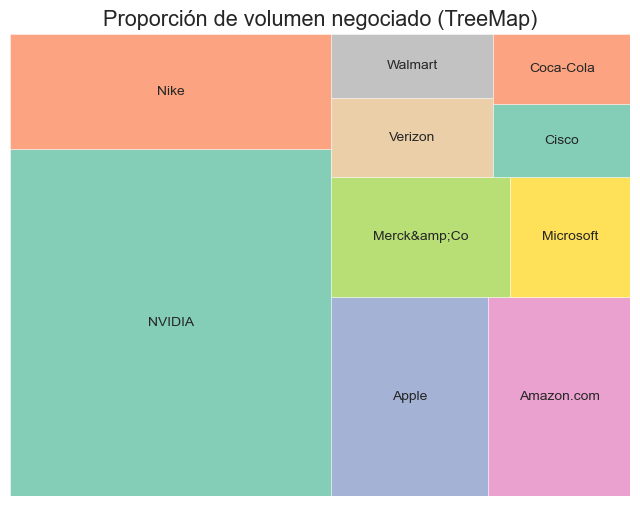

In [40]:
import squarify
plt.figure(figsize=(8,6))
squarify.plot(sizes=top10['vol_'], label=top10['name'], alpha=.8, color=sns.color_palette("Set2"))
plt.title("Proporción de volumen negociado (TreeMap)")
plt.axis('off')
plt.show()